In [1]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# nous lisons le fichier csv
path=r"Input_projet_LVMH.csv"

data= pd.read_csv(path,sep=";")
# nous affichons les types de données et les valeurs manquantes
data.info()
print(data.isnull().sum())


<class 'pandas.DataFrame'>
RangeIndex: 5119 entries, 0 to 5118
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    5119 non-null   str    
 1   clot    5119 non-null   float64
dtypes: float64(1), str(1)
memory usage: 80.1 KB
date    0
clot    0
dtype: int64


<Figure size 1400x600 with 0 Axes>

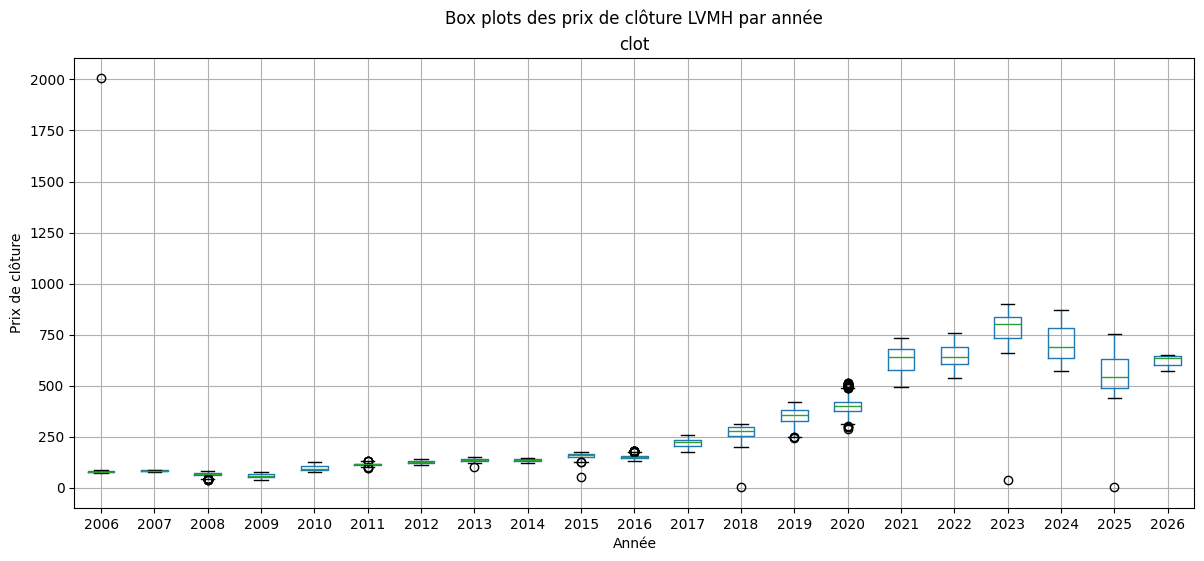

In [11]:

# Convertir la colonne date en datetime
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')

# Extraire l'année
data['year'] = data['date'].dt.year

# Créer les box plots par année
plt.figure(figsize=(14, 6))
data.boxplot(column='clot', by='year', figsize=(14, 6))
plt.suptitle('Box plots des prix de clôture LVMH par année')
plt.xlabel('Année')
plt.ylabel('Prix de clôture')
plt.show()


In [13]:
# Vérifier les types
print(data.dtypes)

# Convertir la colonne 'clot' en numérique
data["clot"] = (
    data["clot"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .astype(float)
)


date    datetime64[us]
clot           float64
year             int32
dtype: object


In [14]:
data = data.sort_values("date").reset_index(drop=True)

data["ret"] = data["clot"].pct_change()
data["vol20"] = data["ret"].rolling(20).std()

print(data.dtypes)


date     datetime64[us]
clot            float64
year              int32
ret             float64
vol20           float64
dtype: object


In [15]:
data["date"] = pd.to_datetime(data["date"], format="%d/%m/%Y")
data = data.sort_values("date").reset_index(drop=True)

# Exemple de features adaptées time series :
# - rendement journalier
# - volatilité rolling (20 jours) du rendement
data["ret"] = data["clot"].pct_change()
data["vol20"] = data["ret"].rolling(20).std()

df = data.dropna(subset=["ret", "vol20"]).copy()

X = df[["ret", "vol20"]].values

# (Optionnel mais recommandé) Standardisation
X_mu = X.mean(axis=0)
X_std = X.std(axis=0, ddof=0)
Xn = (X - X_mu) / X_std

# =========================
# 2) Fonctions du notebook
# =========================
def estimate_gaussian(X):
    """
    Retourne mu et var (variance par feature) en supposant covariance diagonale.
    """
    m, n = X.shape
    mu = (1 / m) * np.sum(X, axis=0)
    var = (1 / m) * np.sum((X - mu) ** 2, axis=0)
    return mu, var

def multivariate_gaussian(X, mu, var):
    """
    Densité d'une gaussienne multivariée avec covariance diagonale (var).
    Retourne p(x) pour chaque ligne de X.
    """
    k = len(mu)
    # éviter divisions par 0
    var = np.where(var == 0, 1e-12, var)

    norm = (2 * np.pi) ** (-k / 2) * (np.prod(var) ** (-0.5))
    exp_term = np.exp(-0.5 * np.sum(((X - mu) ** 2) / var, axis=1))
    return norm * exp_term

# =========================
# 3) Entraîner + scorer
# =========================
mu, var = estimate_gaussian(Xn)
p = multivariate_gaussian(Xn, mu, var)

# =========================
# 4) Choisir epsilon (non supervisé)
# =========================
# Exemple: on marque comme anomalies les 0.5% points les moins probables
epsilon = np.percentile(p, 0.5)

df["p"] = p
df["is_anomaly"] = df["p"] < epsilon

anomalies = df[df["is_anomaly"]].copy()

print("epsilon =", epsilon)
print("Nb anomalies détectées :", len(anomalies))

# Afficher les anomalies (dates + prix)
print(anomalies[["date", "clot", "ret", "vol20", "p"]].head(20))

epsilon = 7.155280980740065e-21
Nb anomalies détectées : 26
           date     clot         ret      vol20             p
100  2006-06-15  2006.25   27.457447   6.140711  2.438814e-40
3071 2018-01-23   244.60  115.476190  25.834408  0.000000e+00
3072 2018-01-24   241.20   -0.013900  25.834434  3.124426e-34
3073 2018-01-25   240.15   -0.004353  25.834571  3.122303e-34
3074 2018-01-26   251.90    0.048928  25.833838  3.136836e-34
3075 2018-01-29   252.60    0.002779  25.833692  3.138741e-34
3076 2018-01-30   251.45   -0.004553  25.833550  3.141101e-34
3077 2018-01-31   252.60    0.004573  25.833567  3.141115e-34
3078 2018-02-01   252.15   -0.001781  25.833725  3.137985e-34
3079 2018-02-02   247.90   -0.016855  25.834107  3.130311e-34
3080 2018-02-05   242.45   -0.021985  25.834176  3.128777e-34
3081 2018-02-06   236.15   -0.025985  25.834508  3.122459e-34
3082 2018-02-07   245.00    0.037476  25.833878  3.136040e-34
3083 2018-02-08   237.45   -0.030816  25.834094  3.129815e-34
3084 2018-

In [16]:
import pandas as pd
import numpy as np

path = "Input_projet_LVMH.csv"
data = pd.read_csv(path, sep=";")

data["date"] = pd.to_datetime(data["date"], format="%d/%m/%Y")
data["quarter"] = data["date"].dt.to_period("Q")


data["clot"] = (
    data["clot"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .astype(float)
)

data = data.sort_values("date").reset_index(drop=True)

data["ret"] = data["clot"].pct_change()
data["vol20"] = data["ret"].rolling(20).std()
data["year"] = data["date"].dt.year

df = data.dropna(subset=["ret", "vol20"]).copy()


In [17]:
def estimate_gaussian(X):
    m = X.shape[0]
    mu = np.mean(X, axis=0)
    var = np.mean((X - mu) ** 2, axis=0)
    return mu, var

def multivariate_gaussian(X, mu, var):
    k = len(mu)
    var = np.where(var == 0, 1e-12, var)
    norm = (2 * np.pi) ** (-k / 2) * np.prod(var) ** (-0.5)
    exp_term = np.exp(-0.5 * np.sum(((X - mu) ** 2) / var, axis=1))
    return norm * exp_term

In [18]:
results = []

for quarter, g in df.groupby("quarter"):

    # Sécurité : éviter les années trop courtes
    if len(g) < 20:
        continue

    X = g[["ret", "vol20"]].values

    # Standardisation par année
    mu_X = X.mean(axis=0)
    std_X = X.std(axis=0, ddof=0)
    Xn = (X - mu_X) / std_X

    mu, var = estimate_gaussian(Xn)
    p = multivariate_gaussian(Xn, mu, var)

    # seuil annuel (0.5 % des points les plus rares)
    epsilon = np.percentile(p, 0.5)

    g = g.copy()
    g["p"] = p
    g["is_anomaly"] = g["p"] < epsilon
    g["epsilon"] = epsilon

    results.append(g)

df_yearly = pd.concat(results)
anomalies = df_yearly[df_yearly["is_anomaly"]]

print("Nombre total d'anomalies :", len(anomalies))
print(anomalies[["date", "year", "clot", "ret", "vol20", "p"]].head(len(anomalies)))


Nombre total d'anomalies : 80
           date  year     clot        ret      vol20             p
28   2006-03-02  2006    79.35   0.036577   0.011625  8.053322e-04
100  2006-06-15  2006  2006.25  27.457447   6.140711  1.181979e-15
118  2006-07-11  2006    75.90  -0.019380   6.154110  1.403183e-03
221  2006-12-01  2006    76.15  -0.027458   0.014083  1.625648e-03
272  2007-02-15  2007    87.70   0.058540   0.015961  3.604770e-06
...         ...   ...      ...        ...        ...           ...
4790 2024-10-08  2024   655.50  -0.043764   0.032225  1.998786e-03
4859 2025-01-16  2025   695.50   0.091494   0.025725  2.006053e-06
4922 2025-04-15  2025   488.65  -0.078193   0.028575  2.614560e-04
4987 2025-07-18  2025   472.75  89.047619  19.923828  3.886896e-16
5050 2025-10-15  2025   597.90   0.122185   0.034170  3.495342e-09

[80 rows x 6 columns]


In [1]:
import pandas as pd
import numpy as np

path = "Input_projet_LVMH.csv"
data = pd.read_csv(path, sep=";")

data["date"] = pd.to_datetime(data["date"], format="%d/%m/%Y")
data["quarter"] = data["date"].dt.to_period("Q")


data["clot"] = (
    data["clot"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .astype(float)
)

data = data.sort_values("date").reset_index(drop=True)

data["ret"] = data["clot"].pct_change()
data["vol20"] = data["ret"].rolling(20).std()
data["year"] = data["date"].dt.year

df = data.dropna(subset=["ret", "vol20"]).copy()


In [2]:
def estimate_gaussian(X):
    m = X.shape[0]
    mu = np.mean(X, axis=0)
    var = np.mean((X - mu) ** 2, axis=0)
    return mu, var

def multivariate_gaussian(X, mu, var):
    k = len(mu)
    var = np.where(var == 0, 1e-12, var)
    norm = (2 * np.pi) ** (-k / 2) * np.prod(var) ** (-0.5)
    exp_term = np.exp(-0.5 * np.sum(((X - mu) ** 2) / var, axis=1))
    return norm * exp_term


In [3]:
results = []

for quarter, g in df.groupby("quarter"):

    

    X = g[["ret", "vol20"]].values

    # Standardisation par trimestre
    mu_X = X.mean(axis=0)
    std_X = X.std(axis=0, ddof=0)
    Xn = (X - mu_X) / std_X

    mu, var = estimate_gaussian(Xn)
    p = multivariate_gaussian(Xn, mu, var)

    # seuil trimestriel (1% recommandé)
    epsilon = np.percentile(p, 1.0)

    g = g.copy()
    g["p"] = p
    g["is_anomaly"] = g["p"] < epsilon
    g["epsilon"] = epsilon

    results.append(g)

df_quarterly = pd.concat(results)


In [4]:

anomalies = df_quarterly[df_quarterly["is_anomaly"]]

df_quarterly = df_quarterly.sort_values("date")

df_quarterly["is_anomaly_extended"] = (
    df_quarterly["is_anomaly"] |
    df_quarterly["is_anomaly"].shift(-1)
)


print("Nombre total d'anomalies :", len(anomalies))
print(anomalies[["date", "quarter", "clot", "ret", "vol20", "p"]].head(20))

Nombre total d'anomalies : 81
           date quarter      clot        ret     vol20             p
28   2006-03-02  2006Q1    79.350   0.036577  0.011625  8.053322e-04
100  2006-06-15  2006Q2  2006.250  27.457447  6.140711  1.181979e-15
118  2006-07-11  2006Q3    75.900  -0.019380  6.154110  1.403183e-03
221  2006-12-01  2006Q4    76.150  -0.027458  0.014083  1.625648e-03
272  2007-02-15  2007Q1    87.700   0.058540  0.015961  3.604770e-06
354  2007-06-14  2007Q2    86.300   0.024332  0.009934  1.980719e-03
399  2007-08-16  2007Q3    77.490  -0.031254  0.016607  4.591349e-03
473  2007-11-28  2007Q4    82.400   0.033358  0.015131  5.938002e-04
511  2008-01-24  2008Q1    70.310   0.089740  0.031940  5.542361e-05
568  2008-04-16  2008Q2    69.330   0.040210  0.022646  1.355216e-03
622  2008-07-02  2008Q3    65.770  -0.005594  0.013624  2.763600e-03
695  2008-10-13  2008Q4    58.180   0.129051  0.045793  2.529136e-03
776  2009-02-06  2009Q1    50.020   0.126577  0.048386  2.875299e-05
829 

In [5]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [6]:
display(
    df_quarterly[df_quarterly["is_anomaly_extended"]]
)

,date,clot,quarter,ret,vol20,year,p,is_anomaly,epsilon,is_anomaly_extended
27,2006-03-01,76.550,2006Q1,0.003934,0.008542,2006,5.272578e-02,False,2.435359e-03,True
28,2006-03-02,79.350,2006Q1,0.036577,0.011625,2006,8.053322e-04,True,2.435359e-03,True
99,2006-06-14,70.500,2006Q2,0.012931,0.025670,2006,1.404555e-01,False,1.113658e-02,True
100,2006-06-15,2006.250,2006Q2,27.457447,6.140711,2006,1.181979e-15,True,1.113658e-02,True
117,2006-07-10,77.400,2006Q3,0.014417,6.154233,2006,2.651067e-03,False,1.474922e-03,True
118,2006-07-11,75.900,2006Q3,-0.019380,6.154110,2006,1.403183e-03,True,1.474922e-03,True
220,2006-11-30,78.300,2006Q4,-0.024299,0.012885,2006,9.429630e-03,False,2.325404e-03,True
221,2006-12-01,76.150,2006Q4,-0.027458,0.014083,2006,1.625648e-03,True,2.325404e-03,True
271,2007-02-14,82.850,2007Q1,0.010366,0.009933,2007,7.001474e-02,False,2.922135e-04,True
272,2007-02-15,87.700,2007Q1,0.058540,0.015961,2007,3.604770e-06,True,2.922135e-04,True


In [8]:
import pandas as pd
import numpy as np

# ============================================================
# 1. Chargement des données
# ============================================================

path = "Input_projet_LVMH.csv"
data = pd.read_csv(path, sep=";")

# Conversion de la colonne date en format datetime
data["date"] = pd.to_datetime(data["date"], format="%d/%m/%Y")

# Création d’une variable temporelle "trimestre"
data["quarter"] = data["date"].dt.to_period("Q")

# ============================================================
# 2. Nettoyage et préparation des données
# ============================================================

# Conversion de la colonne de clôture en float
# (gestion du séparateur décimal ",")
data["clot"] = (
    data["clot"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .astype(float)
)

# Tri chronologique (important pour les séries temporelles)
data = data.sort_values("date").reset_index(drop=True)

# Calcul du rendement journalier
data["ret"] = data["clot"].pct_change()

# Calcul de la volatilité glissante sur 20 jours
data["vol20"] = data["ret"].rolling(20).std()

# Extraction de l’année (utile pour analyses temporelles)
data["year"] = data["date"].dt.year

# Suppression des lignes avec valeurs manquantes
df = data.dropna(subset=["ret", "vol20"]).copy()

# ============================================================
# 3. Fonctions pour le modèle de détection d’anomalies
#    (Gaussienne multivariée)
# ============================================================

def estimate_gaussian(X):
    """
    Estime les paramètres (moyenne et variance)
    d’une distribution gaussienne multivariée.
    """
    mu = np.mean(X, axis=0)
    var = np.mean((X - mu) ** 2, axis=0)
    return mu, var


def multivariate_gaussian(X, mu, var):
    """
    Calcule la densité de probabilité
    d’une loi gaussienne multivariée.
    """
    k = len(mu)

    # Sécurité numérique pour éviter division par zéro
    var = np.where(var == 0, 1e-12, var)

    norm = (2 * np.pi) ** (-k / 2) * np.prod(var) ** (-0.5)
    exp_term = np.exp(-0.5 * np.sum(((X - mu) ** 2) / var, axis=1))
    return norm * exp_term

# ============================================================
# 4. Détection d’anomalies par trimestre
# ============================================================

results = []

# Le modèle est entraîné indépendamment pour chaque trimestre
for quarter, g in df.groupby("quarter"):

    # Variables utilisées pour la détection d’anomalies
    X = g[["ret", "vol20"]].values

    # Standardisation des variables (centrage-réduction)
    # afin d’éviter l’influence des échelles
    mu_X = X.mean(axis=0)
    std_X = X.std(axis=0, ddof=0)
    Xn = (X - mu_X) / std_X

    # Estimation des paramètres de la gaussienne
    mu, var = estimate_gaussian(Xn)

    # Calcul de la probabilité de chaque observation
    p = multivariate_gaussian(Xn, mu, var)

    # Seuil d’anomalie : 1% des observations les plus rares
    epsilon = np.percentile(p, 1.0)

    # Sauvegarde des résultats
    g = g.copy()
    g["p"] = p
    g["is_anomaly"] = g["p"] < epsilon
    g["epsilon"] = epsilon

    results.append(g)

# Fusion de tous les trimestres
df_quarterly = pd.concat(results)

# ============================================================
# 5. Post-traitement des anomalies
# ============================================================

# Extraction des anomalies strictes
anomalies = df_quarterly[df_quarterly["is_anomaly"]]

# Tri chronologique final
df_quarterly = df_quarterly.sort_values("date")

# Extension des anomalies :
# on marque également le jour suivant comme suspect
df_quarterly["is_anomaly_extended"] = (
    df_quarterly["is_anomaly"] |
    df_quarterly["is_anomaly"].shift(-1)
)

# ============================================================
# 6. Affichage des résultats
# ============================================================

print("Nombre d'anomalies detectées :", len(anomalies))
print(
    anomalies[["date", "quarter", "clot", "ret", "vol20", "p"]].head(20)
)

# Affichage complet du tableau
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Tableau des jours et des lendemains des anomalies detectées
print("Nombre d'anomalies detectées avec retard d'un jour :", len(df_quarterly[df_quarterly["is_anomaly_extended"]]))
display(
    df_quarterly[df_quarterly["is_anomaly_extended"]]
)


Nombre d'anomalies detectées : 81
           date quarter      clot        ret     vol20             p
28   2006-03-02  2006Q1    79.350   0.036577  0.011625  8.053322e-04
100  2006-06-15  2006Q2  2006.250  27.457447  6.140711  1.181979e-15
118  2006-07-11  2006Q3    75.900  -0.019380  6.154110  1.403183e-03
221  2006-12-01  2006Q4    76.150  -0.027458  0.014083  1.625648e-03
272  2007-02-15  2007Q1    87.700   0.058540  0.015961  3.604770e-06
354  2007-06-14  2007Q2    86.300   0.024332  0.009934  1.980719e-03
399  2007-08-16  2007Q3    77.490  -0.031254  0.016607  4.591349e-03
473  2007-11-28  2007Q4    82.400   0.033358  0.015131  5.938002e-04
511  2008-01-24  2008Q1    70.310   0.089740  0.031940  5.542361e-05
568  2008-04-16  2008Q2    69.330   0.040210  0.022646  1.355216e-03
622  2008-07-02  2008Q3    65.770  -0.005594  0.013624  2.763600e-03
695  2008-10-13  2008Q4    58.180   0.129051  0.045793  2.529136e-03
776  2009-02-06  2009Q1    50.020   0.126577  0.048386  2.875299e-05


,date,clot,quarter,ret,vol20,year,p,is_anomaly,epsilon,is_anomaly_extended
27,2006-03-01,76.550,2006Q1,0.003934,0.008542,2006,5.272578e-02,False,2.435359e-03,True
28,2006-03-02,79.350,2006Q1,0.036577,0.011625,2006,8.053322e-04,True,2.435359e-03,True
99,2006-06-14,70.500,2006Q2,0.012931,0.025670,2006,1.404555e-01,False,1.113658e-02,True
100,2006-06-15,2006.250,2006Q2,27.457447,6.140711,2006,1.181979e-15,True,1.113658e-02,True
117,2006-07-10,77.400,2006Q3,0.014417,6.154233,2006,2.651067e-03,False,1.474922e-03,True
118,2006-07-11,75.900,2006Q3,-0.019380,6.154110,2006,1.403183e-03,True,1.474922e-03,True
220,2006-11-30,78.300,2006Q4,-0.024299,0.012885,2006,9.429630e-03,False,2.325404e-03,True
221,2006-12-01,76.150,2006Q4,-0.027458,0.014083,2006,1.625648e-03,True,2.325404e-03,True
271,2007-02-14,82.850,2007Q1,0.010366,0.009933,2007,7.001474e-02,False,2.922135e-04,True
272,2007-02-15,87.700,2007Q1,0.058540,0.015961,2007,3.604770e-06,True,2.922135e-04,True
